<a href="https://colab.research.google.com/github/glucard/Leaves-dataset/blob/colab/Colab/models/Leaves_model_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

import os
import tensorflow as tf

# parace que tem que abrir o link com o navegador primeiro para que o download pelo colab funcione.
_URL = 'https://github.com/glucard/Leaves-dataset/archive/refs/heads/fix_rename.zip'
path_to_zip = tf.keras.utils.get_file('Leaves-dataset-fix_rename.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'Leaves-dataset-fix_rename')

leaves_dataset_dir = os.path.join(PATH, 'data')
BATCH_SIZE = 30
IMG_SIZE = (244, 244)

leaves_dataset = tf.keras.utils.image_dataset_from_directory(leaves_dataset_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            color_mode='rgb',
                                                            image_size=IMG_SIZE,
                                                            crop_to_aspect_ratio=False,
                                                             )
leaves_dataset

Found 616 files belonging to 11 classes.


<BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
leaves_dataset_lenght = leaves_dataset.cardinality().numpy()

train_dataset = leaves_dataset.take(leaves_dataset_lenght//4 * 3)
#train_dataset = train_dataset.unbatch().batch(BATCH_SIZE)

validation_dataset = leaves_dataset.skip(leaves_dataset_lenght//4 *3)
#validation_dataset = leaves_dataset.unbatch().batch(BATCH_SIZE)

In [ ]:
def image_standardization(image,label):
  """image = tf.image.per_image_standardization(image)"""
  image = tf.math.subtract(image, tf.math.reduce_mean(image))
  return image, label

train_dataset = train_dataset.map(image_standardization)
validation_dataset = validation_dataset.map(image_standardization)

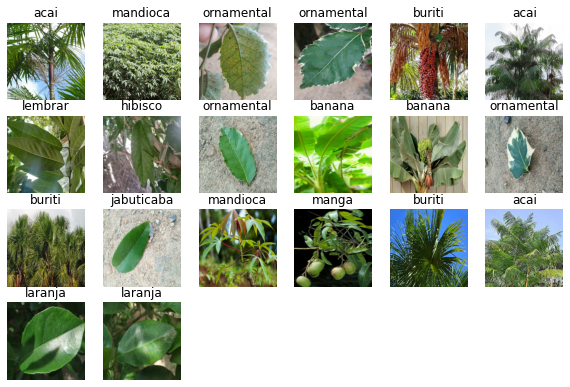

In [ ]:
import matplotlib.pyplot as plt

class_names = leaves_dataset.class_names

plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
  for i in range(20):
    ax = plt.subplot(6, 6, i + 1)
    img = tf.keras.utils.array_to_img(images[i].numpy())
    plt.imshow(img)
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset) # lenght dataset
print(validation_dataset)
print(val_batches)

<MapDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(6, shape=(), dtype=int64)


In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset) # lenght dataset
print(validation_dataset)
print(val_batches)
test_dataset = validation_dataset.take(val_batches // 2) # lenght//5 first elements in test_dataset
# validation_dataset = validation_dataset.skip(val_batches // 2) # skipping elements used in test_dataset

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

<MapDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
tf.Tensor(6, shape=(), dtype=int64)
Number of validation batches: 6
Number of test batches: 3


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

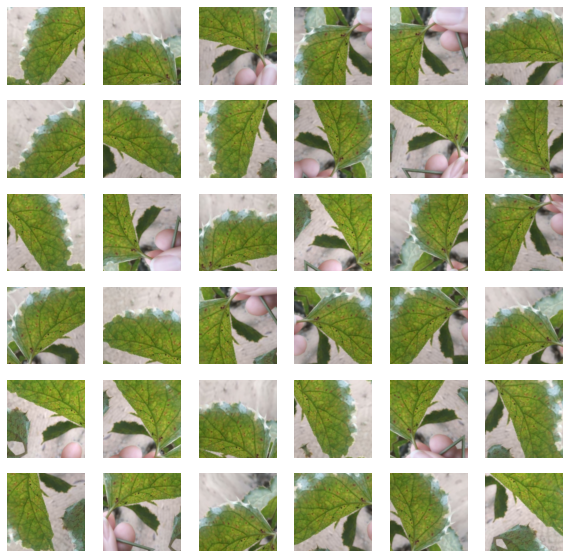

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomCrop(150, 150),
  tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1]),
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation((-0.2, 0.3)),
])

for image, _ in test_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(36):
    ax = plt.subplot(6, 6, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0), training=True) # tf.expand_dims() é só pro sample ser tratado como um batch (160,160,3) -> (1,160,160,3)
    
    img = tf.keras.utils.array_to_img(augmented_image[0])

    plt.imshow(img)
    plt.axis('off')

# corrigir bug data_augmentation not working:
# https://stackoverflow.com/questions/71164259/tensorflow-augmentation-layers-not-working-after-importing-from-tf-keras-applica

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV3Large(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet') # include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.
base_model.summary()

(244, 244, 3)
Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_16 (Rescaling)       (None, 244, 244, 3)  0           ['input_16[0][0]']               
                                                                                                  
 Conv (Conv2D)                  (None, 122, 122, 16  432         ['rescaling_16[0][0]']           
                                )                                                                 
                                                                     

In [ ]:
# This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features.
# Let's see what it does to an example batch of images:

image_batch, label_batch = next(iter(train_dataset)) # next(iter()) parece uma fila.
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(30, 8, 8, 960)


In [ ]:
base_model.trainable = False

In [ ]:
conv2_layer_0 = tf.keras.layers.Conv2D(16, kernel_size=(2, 2), activation='relu',
                                       #kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3)
                                       )
conv2_layer_1 = tf.keras.layers.Conv2D(8, kernel_size=(3, 3), activation='relu',
                                       #kernel_regularizer=tf.keras.regularizers.L1L2(l1=1e-4, l2=1e-3)
                                       )



# global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
flatten_layer = tf.keras.layers.Flatten()
"""
hidden_layer = tf.keras.layers.Dense(800, activation='relu',
                                         #kernel_regularizer=tf.keras.regularizers.L1(0.002),
                                         #activity_regularizer=tf.keras.regularizers.L2(0.002)
                                         )
hidden_layer_1 = tf.keras.layers.Dense(800, activation='relu',
                                         #kernel_regularizer=tf.keras.regularizers.L1(0.002),
                                         #activity_regularizer=tf.keras.regularizers.L2(0.002)
                                         )
hidden_layer_2 = tf.keras.layers.Dense(400, activation='relu',
                                         #kernel_regularizer=tf.keras.regularizers.L1(0.002),
                                         #activity_regularizer=tf.keras.regularizers.L2(0.002)
                                         )
hidden_layer_3 = tf.keras.layers.Dense(400, activation='relu',
                                         #kernel_regularizer=tf.keras.regularizers.L1(0.002),
                                         #activity_regularizer=tf.keras.regularizers.L2(0.002)
                                         )
hidden_layer_4 = tf.keras.layers.Dense(200, activation='relu',
                                         #kernel_regularizer=tf.keras.regularizers.L1(0.002),
                                         #activity_regularizer=tf.keras.regularizers.L2(0.002)
                                         )
hidden_layer_5 = tf.keras.layers.Dense(200, activation='relu',
                                         #kernel_regularizer=tf.keras.regularizers.L1(0.002),
                                         #activity_regularizer=tf.keras.regularizers.L2(0.002)
                                         )
hidden_layer_6 = tf.keras.layers.Dense(100, activation='relu',
                                         #kernel_regularizer=tf.keras.regularizers.L1(0.002),
                                         #activity_regularizer=tf.keras.regularizers.L2(0.002)
                                         )"""
hidden_layer_0 = tf.keras.layers.Dense(32, activation='relu',
                                         kernel_regularizer=tf.keras.regularizers.L1(1e-2),
                                         activity_regularizer=tf.keras.regularizers.L2(1e-2)
                                         )
prediction_layer = tf.keras.layers.Dense(11, activation='softmax') # não esquecer de trocar numero de classes ao alterar o dataset ou colocar a propria dimensão de classes do dataset

# adicionar mais camada de conv e é isso
"""hidden_batch = hidden_layer(feature_batch_average)
hidden_batch_1 = hidden_layer_1(hidden_batch)
hidden_batch_2 = hidden_layer_2(hidden_batch_1)
hidden_batch_3 = hidden_layer_3(hidden_batch_2)
hidden_batch_4 = hidden_layer_4(hidden_batch_3)
hidden_batch_5 = hidden_layer_5(hidden_batch_4)
hidden_batch_6 = hidden_layer_6(hidden_batch_5)
prediction_batch = prediction_layer(hidden_batch_6)"""

conv2_batch_0 = conv2_layer_0(feature_batch)
conv2_batch_1 = conv2_layer_1(conv2_batch_0)
# feature_batch_average = global_average_layer(conv2_batch_1)
flatten_batch = flatten_layer(conv2_batch_1)
hidden_batch_0 = hidden_layer_0(flatten_batch)
prediction_batch = prediction_layer(hidden_batch_0)

print(prediction_batch.shape)

(30, 11)


In [ ]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = conv2_layer_0(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = conv2_layer_1(x)
x = tf.keras.layers.Dropout(0.2)(x)
# x = global_average_layer(x)
x = flatten_layer(x)
"""
#x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer_1(x)
#x = tf.keras.layers.Dropout(0.2)(x)
x = hidden_layer_2(x)
x = hidden_layer_3(x)
x = hidden_layer_4(x)
x = hidden_layer_5(x)
x = hidden_layer_6(x)
"""
x = hidden_layer_0(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 244, 244, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 244, 244, 3)       0         
                                                                 
 MobilenetV3large (Functiona  (None, 8, 8, 960)        2996352   
 l)                                                              
                                                                 
 conv2d_14 (Conv2D)          (None, 7, 7, 16)          61456     
                                                                 
 dropout_21 (Dropout)        (None, 7, 7, 16)          0         
                                                                 
 conv2d_15 (Conv2D)          (None, 5, 5, 8)           1160      
                                                          

In [ ]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

6/6 [==============================] - 4s 59ms/step - loss: 9.1436 - accuracy: 0.0663
initial loss: 9.14
initial accuracy: 0.07


In [ ]:
print(model.evaluate(test_dataset))

3/3 [==============================] - 2s 68ms/step - loss: 9.1806 - accuracy: 0.0667
[9.180557250976562, 0.06666667014360428]


In [1]:
initial_epochs = 35

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

NameError: ignored

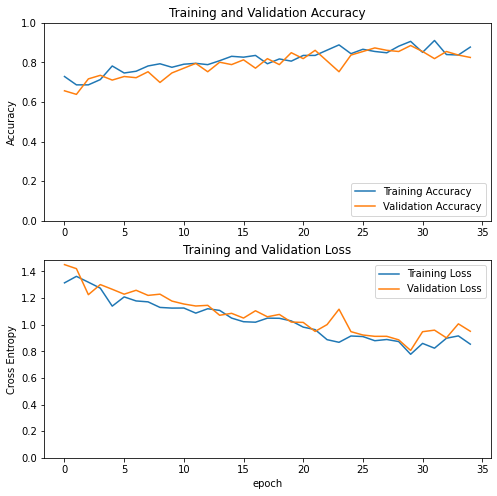

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(test_dataset)

3/3 [==============================] - 2s 69ms/step - loss: 0.8863 - accuracy: 0.8778


[0.8863211870193481, 0.8777777552604675]

In [ ]:
from sklearn.metrics import classification_report
for images, labels in test_dataset.unbatch().batch(616).take(1):
  y_pred = np.argmax(model.predict(images), axis=1)
  print(classification_report(labels.numpy(), y_pred, target_names=class_names))

3/3 [==============================] - 0s 60ms/step
              precision    recall  f1-score   support

        acai       0.75      0.75      0.75         4
      banana       0.80      0.67      0.73         6
      buriti       0.86      1.00      0.92         6
     cupuacu       0.83      0.71      0.77         7
     hibisco       0.90      0.90      0.90        10
  jabuticaba       1.00      0.50      0.67         8
     laranja       0.64      0.90      0.75        10
     lembrar       0.93      1.00      0.97        14
    mandioca       0.50      1.00      0.67         3
       manga       0.89      0.73      0.80        11
  ornamental       1.00      0.91      0.95        11

    accuracy                           0.83        90
   macro avg       0.83      0.82      0.81        90
weighted avg       0.86      0.83      0.83        90



In [ ]:
for imgs in test_dataset.take(1):
  img = imgs[0][0]
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)

In [ ]:
"""for layer in model.layers:
 # check for convolutional layer
 if 'conv' not in layer.name:
  continue
 # get filter weights
 filters, biases = layer.get_weights()
 print(layer.name, filters.shape)"""

ixs = []
for i in range(len(base_model.layers)):
  layer = base_model.layers[i]
  # check for convolutional layer
  if 'project/BatchNorm' not in layer.name or 'conv'.upper() not in layer.name.upper() or layer.output.shape[1:3] == (1,1):
    continue
  # summarize output shape
  
  ixs.append(i)
  print(i, layer.name, layer.output.shape)
print(len(ixs))
ixs = [12, len(base_model.layers)-1]

12 expanded_conv/project/BatchNorm (None, 122, 122, 16)
22 expanded_conv_1/project/BatchNorm (None, 61, 61, 24)
30 expanded_conv_2/project/BatchNorm (None, 61, 61, 24)
48 expanded_conv_3/project/BatchNorm (None, 31, 31, 40)
64 expanded_conv_4/project/BatchNorm (None, 31, 31, 40)
81 expanded_conv_5/project/BatchNorm (None, 31, 31, 40)
97 expanded_conv_6/project/BatchNorm (None, 16, 16, 80)
111 expanded_conv_7/project/BatchNorm (None, 16, 16, 80)
126 expanded_conv_8/project/BatchNorm (None, 16, 16, 80)
141 expanded_conv_9/project/BatchNorm (None, 16, 16, 80)
164 expanded_conv_10/project/BatchNorm (None, 16, 16, 112)
186 expanded_conv_11/project/BatchNorm (None, 16, 16, 112)
210 expanded_conv_12/project/BatchNorm (None, 8, 8, 160)
232 expanded_conv_13/project/BatchNorm (None, 8, 8, 160)
255 expanded_conv_14/project/BatchNorm (None, 8, 8, 160)
15


(244, 244, 3)
1/1 [==============================] - 1s 947ms/step
(1, 122, 122, 16)


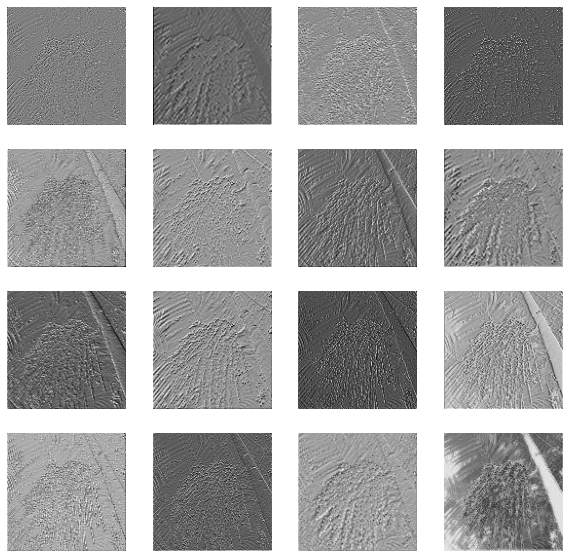

(1, 8, 8, 960)


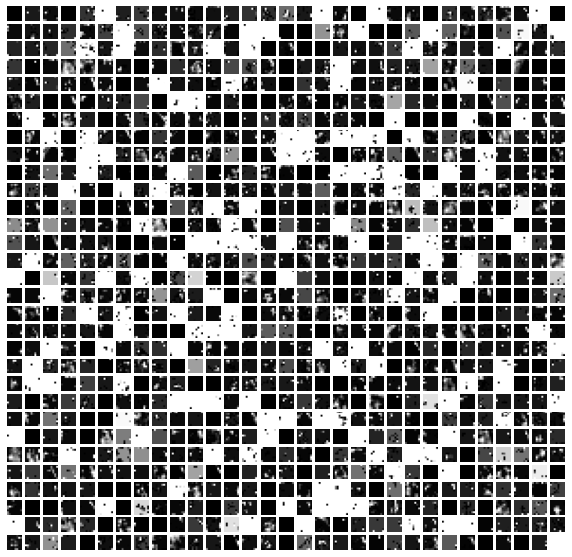

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims

# load the model
# redefine model to output right after the first hidden layer
outputs = [base_model.layers[i].output for i in ixs]
model_f = Model(inputs=base_model.inputs, outputs=outputs)
# load the image with the required shape
for imgs in test_dataset.take(1):
  img = imgs[0][0]
  print(img.shape)  
# convert the image to an array
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model_f.predict(img)
# plot the output from each block
for fmap in feature_maps:
  print(fmap.shape)
  ix = 1
  square = np.sqrt(fmap.shape[3])
  if not square.is_integer():
    square = int(square) + 1
  pyplot.figure(figsize=(10, 10))
  for _ in range(fmap.shape[3]):
      # specify subplot and turn of axis
      # ax = plt.subplot(6, 6, i + 1)
      ax = pyplot.subplot(square, square, ix)
      # plot filter channel in grayscale
      pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
      # show the figure
      pyplot.axis('off')
  pyplot.show()

In [ ]:
ixs = []
for i in range(len(model.layers)):
  layer = model.layers[i]
  # check for convolutional layer
  if 'conv'.upper() not in layer.name.upper():
    continue
  # summarize output shape
  
  ixs.append(i)
  print(i, layer.name, layer.output.shape)

3 conv2d_14 (None, 7, 7, 16)
5 conv2d_15 (None, 5, 5, 8)


1/1 [==============================] - 1s 1s/step
(1, 7, 7, 16)


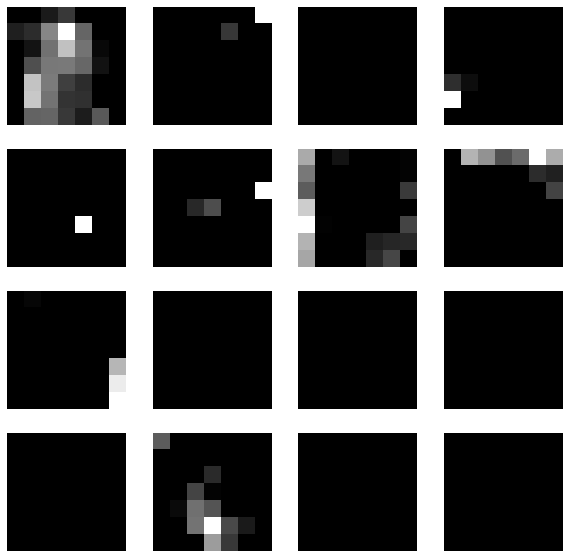

(1, 5, 5, 8)


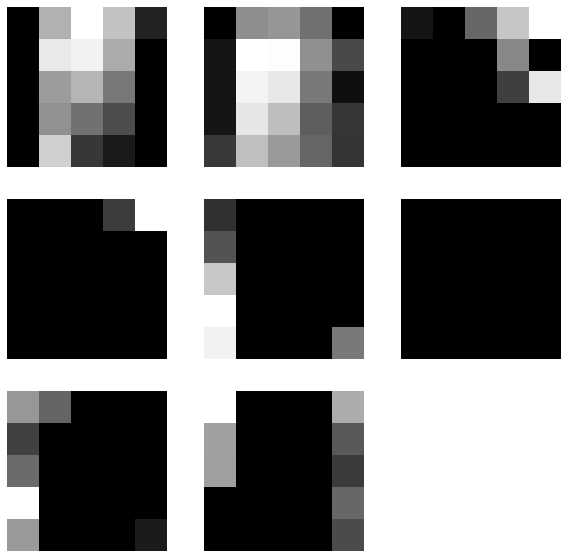

In [ ]:
outputs = [model.layers[i].output for i in ixs]
model_f = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
 
# convert the image to an array

# get feature map for first hidden layer
feature_maps = model_f.predict(img)
# plot the output from each block
for fmap in feature_maps:
  print(fmap.shape)
  ix = 1
  square = np.sqrt(fmap.shape[3])
  if not square.is_integer():
    square = int(square) + 1
  pyplot.figure(figsize=(10, 10))
  for _ in range(fmap.shape[3]):
      # specify subplot and turn of axis
      # ax = plt.subplot(6, 6, i + 1)
      ax = pyplot.subplot(square, square, ix)
      # plot filter channel in grayscale
      pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
      ix += 1
      # show the figure
      pyplot.axis('off')
  pyplot.show()